Clustering is an unsupervised learning procedure that is used to empirically define groups of cells with similar expression profiles. **Its primary purpose is to summarize complex scRNA-seq data into a digestible format for human interpretation.** This allows us to describe population heterogeneity in terms of discrete labels that are easily understood, **rather than attempting to comprehend the high-dimensional manifold on which the cells truly reside**. After annotation based on marker genes, the clusters can be treated as proxies for more abstract biological concepts such as cell types or states.

At this point, it is helpful to realize that clustering, like a microscope, is simply a tool to explore the data. We can zoom in and out by changing the resolution of the clustering parameters, and we can experiment with different clustering algorithms to obtain alternative perspectives of the data. **This iterative approach is entirely permissible given that data exploration constitutes the majority of the scRNA-seq data analysis workflow.** As such, questions about the “correctness” of the clusters or the “true” number of clusters are usually meaningless. We can define as many clusters as we like, with whatever algorithm we like - each clustering will represent its own partitioning of the high-dimensional expression space, and is as “real” as any other clustering.

A more relevant question is “how well do the clusters approximate the cell types or states of interest?” Unfortunately, this is difficult to answer given the context-dependent interpretation of the underlying biology. Some analysts will be satisfied with resolution of the major cell types; other analysts may want resolution of subtypes; and others still may require resolution of different states (e.g., metabolic activity, stress) within those subtypes. **Moreover, two clusterings can be highly inconsistent yet both valid, simply partitioning the cells based on different aspects of biology.** Indeed, asking for an unqualified “best” clustering is akin to asking for the best magnification on a microscope without any context.

In [1]:
library(DropletUtils)
library(scater)

sce.pbmc <- read10xCounts("/home/mowp/data/scRNA/pbmc4k/raw_gene_bc_matrices/GRCh38", col.names=TRUE)

Loading required package: SingleCellExperiment

Loading required package: SummarizedExperiment

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    

In [2]:
rownames(sce.pbmc) <- uniquifyFeatureNames(
    rowData(sce.pbmc)$ID, rowData(sce.pbmc)$Symbol)

library(EnsDb.Hsapiens.v86)
location <- mapIds(EnsDb.Hsapiens.v86, keys=rowData(sce.pbmc)$ID, 
    column="SEQNAME", keytype="GENEID")

Loading required package: ensembldb

Loading required package: GenomicFeatures

Loading required package: AnnotationDbi



Loading required package: AnnotationFilter


Attaching package: 'ensembldb'


The following object is masked from 'package:stats':

    filter


Warning message:
"Unable to map 144 of 33694 requested IDs."


In [3]:
sce.pbmc

class: SingleCellExperiment 
dim: 33694 737280 
metadata(1): Samples
assays(1): counts
rownames(33694): RP11-34P13.3 FAM138A ... AC213203.1 FAM231B
rowData names(2): ID Symbol
colnames(737280): AAACCTGAGAAACCAT-1 AAACCTGAGAAACCGC-1 ...
  TTTGTCATCTTTAGTC-1 TTTGTCATCTTTCCTC-1
colData names(2): Sample Barcode
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [4]:
set.seed(100)
e.out <- emptyDrops(counts(sce.pbmc))
sce.pbmc <- sce.pbmc[,which(e.out$FDR <= 0.001)]

In [5]:
stats <- perCellQCMetrics(sce.pbmc, subsets=list(Mito=which(location=="MT")))
high.mito <- isOutlier(stats$subsets_Mito_percent, type="higher")
sce.pbmc <- sce.pbmc[,!high.mito]

In [6]:
library(scran)
set.seed(1000)
clusters <- quickCluster(sce.pbmc)
sce.pbmc <- computeSumFactors(sce.pbmc, cluster=clusters)
sce.pbmc <- logNormCounts(sce.pbmc)

In [10]:
set.seed(1001)
dec.pbmc <- modelGeneVarByPoisson(sce.pbmc)
top.pbmc <- getTopHVGs(dec.pbmc, prop=0.1)

In [11]:
set.seed(10000)
sce.pbmc <- denoisePCA(sce.pbmc, subset.row=top.pbmc, technical=dec.pbmc)

set.seed(100000)
sce.pbmc <- runTSNE(sce.pbmc, dimred="PCA")

set.seed(1000000)
sce.pbmc <- runUMAP(sce.pbmc, dimred="PCA")

In [12]:
sce.pbmc

class: SingleCellExperiment 
dim: 33694 3985 
metadata(1): Samples
assays(2): counts logcounts
rownames(33694): RP11-34P13.3 FAM138A ... AC213203.1 FAM231B
rowData names(2): ID Symbol
colnames(3985): AAACCTGAGAAGGCCT-1 AAACCTGAGACAGACC-1 ...
  TTTGTCAGTTAAGACA-1 TTTGTCATCCCAAGAT-1
colData names(3): Sample Barcode sizeFactor
reducedDimNames(3): PCA TSNE UMAP
mainExpName: NULL
altExpNames(0):

# Graph-based clustering

Popularized by its use in Seurat, graph-based clustering is a flexible and scalable technique for clustering large scRNA-seq datasets. We first build a graph where each node is a cell that is connected to its nearest neighbors in the high-dimensional space. Edges are weighted based on the similarity between the cells involved, with higher weight given to cells that are more closely related. We then apply algorithms to identify “communities” of cells that are more connected to cells in the same community than they are to cells of different communities. Each community represents a cluster that we can use for downstream interpretation.

The major advantage of graph-based clustering lies in its scalability. It only requires a k-nearest neighbor search that can be done in log-linear time on average, in contrast to hierachical clustering methods with runtimes that are quadratic with respect to the number of cells. Graph construction avoids making strong assumptions about the shape of the clusters or the distribution of cells within each cluster, compared to other methods like k-means (that favor spherical clusters) or Gaussian mixture models (that require normality). From a practical perspective, each cell is forcibly connected to a minimum number of neighboring cells, which reduces the risk of generating many uninformative clusters consisting of one or two outlier cells.

The main drawback of graph-based methods is that, after graph construction, no information is retained about relationships beyond the neighboring cells1. This has some practical consequences in datasets that exhibit differences in cell density, as more steps through the graph are required to move the same distance through a region of higher cell density. From the perspective of community detection algorithms, this effect “inflates” the high-density regions such that any internal substructure or noise is more likely to cause formation of subclusters. The resolution of clustering thus becomes dependent on the density of cells, which can occasionally be misleading if it overstates the heterogeneity in the data.

To demonstrate, we use the `clusterCells()` function in scran on PBMC dataset. All calculations are performed using the top PCs to take advantage of data compression and denoising. This function returns a vector containing cluster assignments for each cell in our SingleCellExperiment object.

In [13]:
library(scran)
nn.clusters <- clusterCells(sce.pbmc, use.dimred="PCA")
table(nn.clusters)

nn.clusters
  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16 
205 508 541  56 374 125  46 432 302 867  47 155 166  61  84  16 

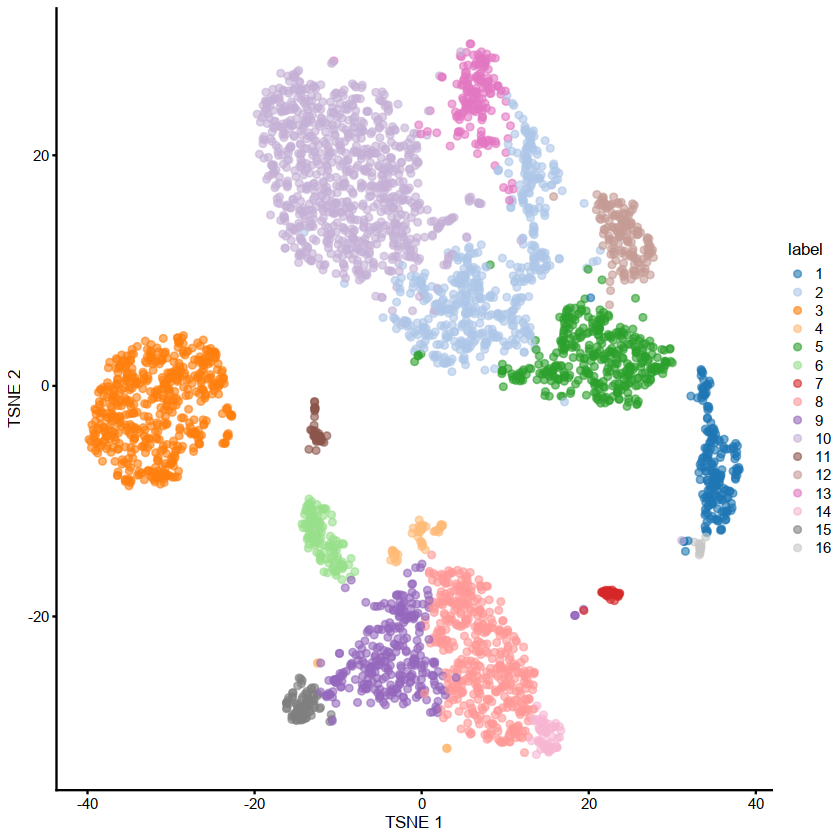

In [14]:
library(scater)
colLabels(sce.pbmc) <- nn.clusters
plotReducedDim(sce.pbmc, "TSNE", colour_by="label")

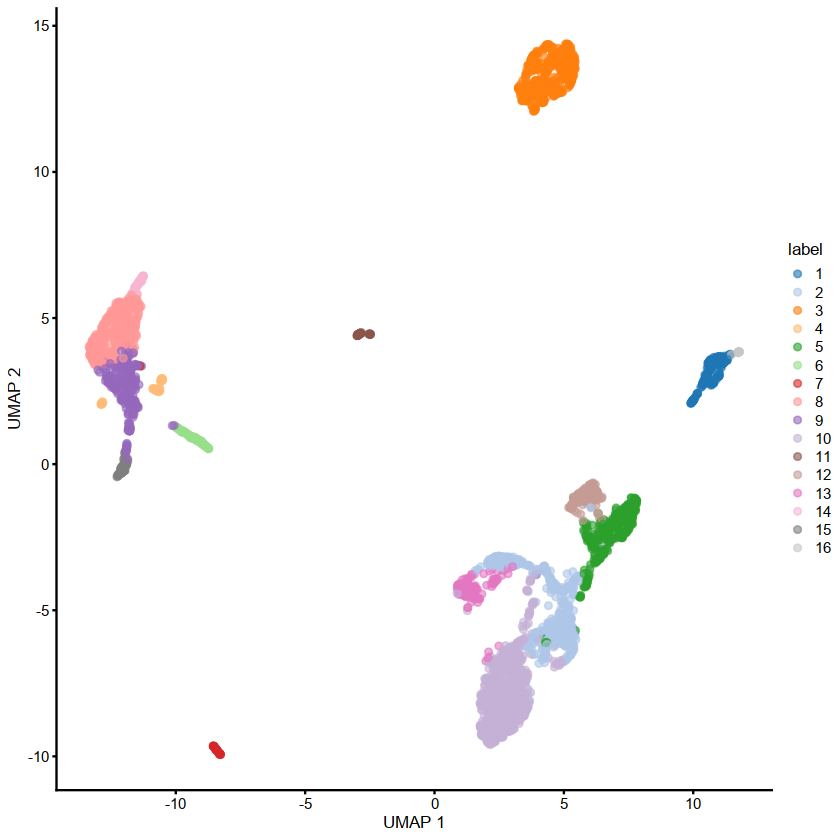

In [15]:
plotReducedDim(sce.pbmc, "UMAP", colour_by="label")

#  Subclustering

Another simple approach to improving resolution is to repeat the feature selection and clustering within a single cluster. This aims to select HVGs and PCs that are more relevant to internal structure, improving resolution by avoiding noise from unnecessary features. Subsetting also encourages clustering methods to separate cells according to more modest heterogeneity in the absence of distinct subpopulations. We demonstrate with a cluster of putative memory T cells from the PBMC dataset, identified according to several markers

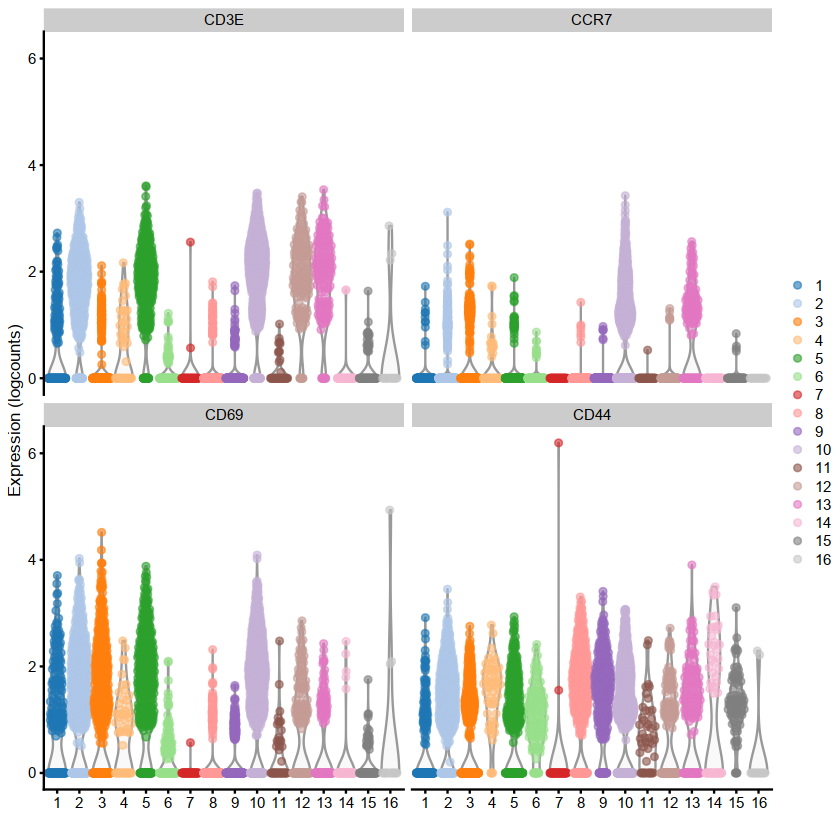

In [17]:
clust.full <- clusterCells(sce.pbmc, use.dimred="PCA")
plotExpression(sce.pbmc, features=c("CD3E", "CCR7", "CD69", "CD44"),
    x=I(clust.full), colour_by=I(clust.full))

In [20]:
# Repeating modelling and PCA on the subset.
memory <- 10L
sce.memory <- sce.pbmc[,clust.full==memory]
dec.memory <- modelGeneVar(sce.memory)
sce.memory <- denoisePCA(sce.memory, technical=dec.memory,
    subset.row=getTopHVGs(dec.memory, n=5000))

In [22]:
sce.memory

class: SingleCellExperiment 
dim: 33694 867 
metadata(1): Samples
assays(2): counts logcounts
rownames(33694): RP11-34P13.3 FAM138A ... AC213203.1 FAM231B
rowData names(2): ID Symbol
colnames(867): AAACCTGAGGCATGGT-1 AAACCTGGTGCGGTAA-1 ...
  TTTGGTTAGGATGGTC-1 TTTGGTTCAGGACGTA-1
colData names(4): Sample Barcode sizeFactor label
reducedDimNames(3): PCA TSNE UMAP
mainExpName: NULL
altExpNames(0):

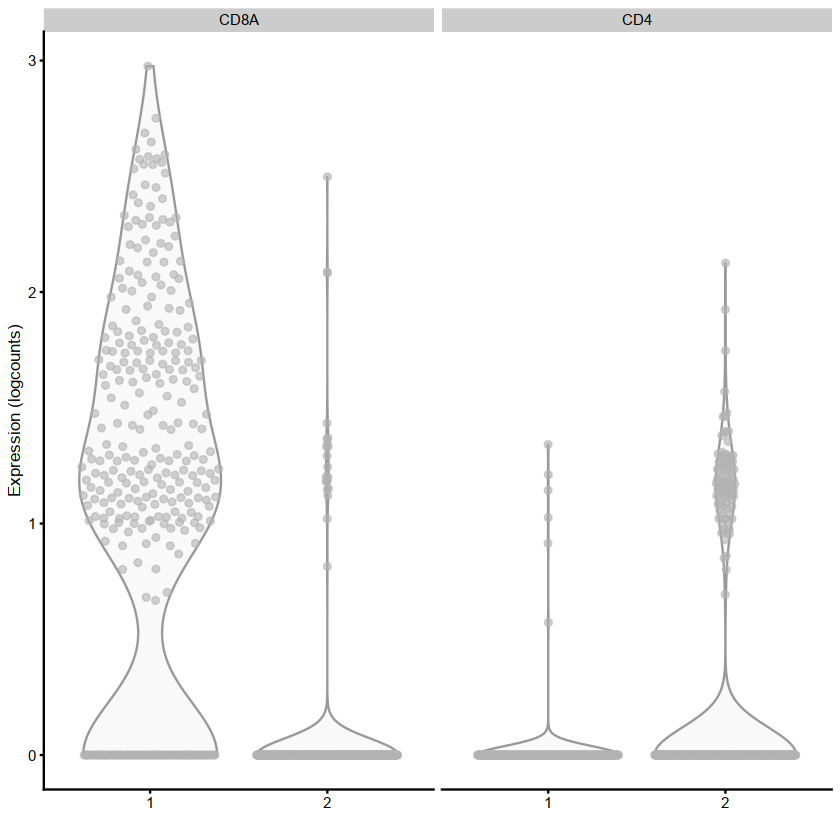

In [21]:
g.memory <- buildSNNGraph(sce.memory, use.dimred="PCA")
clust.memory <- igraph::cluster_walktrap(g.memory)$membership
plotExpression(sce.memory, features=c("CD8A", "CD4"),
    x=I(factor(clust.memory)))